Nathan Rouillé

This second practical work, on motion estimation, deals with parametric motion estimation. You have to reuse some of the functions you implemented during the first practical work.

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [334]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from cv2 import copyMakeBorder,BORDER_REPLICATE

# Parametric estimation
In this second practical work, we will work on parametric estimation, both using direct and indirect methods.
## I- Direct parametric estimation
## I-1 Theoretical questions

**Infinite signal**

Let $a: (n,m)\in \mathbb{Z}^2 \rightarrow \mathbb{R}$ be a bi-dimensional signal and $b(n,m)$ a signal of the same type.

**Recall the expression of the 2D discrete time Fourier transform (DTFT).**

Let us suppose that
$\exists c,d \in \mathbb{Z}^2: \forall n,m \in \mathbb{Z}^2,b(n,m) = a(n+c,m+d)$ (that is, $b$ is a translation of $a$). **Compute the DTFT** of $b$ as a function of the one of $a$ and of the displacement $(c,d)$.

**Show that the ratio between the DTFTs is:**
$$
\frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \exp(i2\pi (c\nu_x + d \nu_y))
$$

**Finite signal**

Now, $a: (n,m) \in \{0,1,...,N-1\}^2 \rightarrow \mathbb{R}$ and $b(n,m)$ are both finite signals. In that case, we use the Discrete Fourier Transform (DFT) rather than the DTFT.

**Recall the expression of the DFT.**

**Under which hypotheses is the ratio between $a$'s and $b$'s DFT a linear phase signal?**
$$
\frac{\hat{B}(k_x,k_y)}{\hat{A}(k_x,k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)
$$

## Réponses

La DTFT 2D de $a(n,m)$ est :
$$
\hat{a}(\nu_x, \nu_y) = \sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} a(n,m) e^{-i2\pi(n\nu_x + m\nu_y)}
$$

Pour $b(n,m) = a(n+c,m+d)$, on a:
$$
\hat{b}(\nu_x,\nu_y) = \sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} a(n+c,m+d) e^{-i2\pi(n\nu_x + m\nu_y)}
$$
Par changement de variable $n' = n+c$ and $m' = m+d$ on obtient :
$$
\hat{b}(\nu_x,\nu_y) = e^{i2\pi (c\nu_x + d\nu_y)} \hat{a}(\nu_x,\nu_y)
$$
Ainsi le rapport des DTFT de $a$ et $b$ est :
$$
\frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \exp(i2\pi (c\nu_x + d \nu_y))
$$

La DFT 2D de $a(n,m)$ est :
$$
\hat{A}(k_x, k_y) = \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} a(n,m) e^{-i \frac{2\pi}{N} (nk_x + mk_y)}
$$

De manière analogue à la question précédente, en rajoutant l'hypothèse que les signaux sont périodiques de période N on obtient :
$$
\frac{\hat{B}(k_x,k_y)}{\hat{A}(k_x,k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)
$$
Le rapport des DFT est donc effectivement un signal à phase linéaire sous l'hypothèse de périodicité.


## I-2 Practical part
First, start to work on the 'ball.mat' image. We will apply a translation to this image and try to estimate the parameter of the translation.

Try by either adding or not some noise into the image.

In [ ]:
im1 = loadmat('ball.mat')['im1']
im1 = im1.astype('float')

#im1 = loadmat('lena.mat')['im1']
#im1 = im1.astype('float')

N, M = np.shape(im1)

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x2acc923e3f0>)

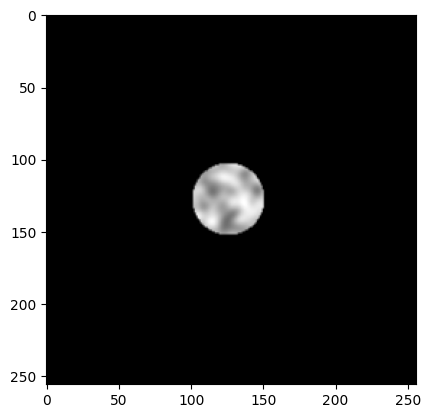

In [ ]:
# Potentially add noise to the image
sigma = 0
im1 = im1 + sigma*np.random.randn(N,M)
plt.figure(),plt.imshow(im1,cmap='gray')

In the following, we apply a translation to the image. To do that, use the applyAffineMotion function which is already pre-implemented.

In [386]:
def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref);
    
    
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement
    
    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    
    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points
    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])    
    
    
    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp =  griddata(points, values, points_inter,'linear')
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp


def applyAffineMotion(x,b,B = np.zeros((2,2)),out = 100):
    N, M = np.shape(x)
    px, py = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1), np.arange(-(N-1)/2,(N-1)/2+1))
    
    mvfx = b[0] + B[0,0]*px + B[0,1]*py
    mvfy = b[1] + B[1,0]*px + B[1,1]*py
    
    mvf = np.zeros((np.shape(mvfx)[0],np.shape(mvfx)[1],2))
    mvf[:,:,1] = mvfx
    mvf[:,:,0] = mvfy
    
    y = fracMc(x,mvf,out)
    return y

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x2acc7f2c680>)

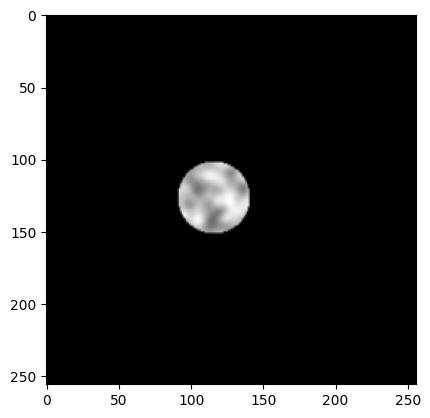

In [ ]:
horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b)
plt.figure(),plt.imshow(im2,cmap='gray')

Compute the FFT of the two images. Using the indications given in the theroretical part, describe a method with which you can find the parameters of the translation from the two FFTs.

**Réponse :**

Pour retrouver les paramètres de la translation, on peut calculer les DFT des 2 images puis déterminer la phase de leur ratio en calculant l'angle en chaque point. Pour des petites translations (inférieures à la moitié de l'image - le rayon du disque) l'image ball.mat est périodique car de fond noir et respecte donc notre hypothèse de périodicité, on a donc une phase linéaire et on peut donc calculer la pente de l'angle (qui est un plan parfait) à partir de 2 points et donc retrouver les paramètres. Pour une image non périodique comme lena.mat ou ball.mat bruitée, on a plus une phase purement périodique et on doit faire une approximation des paramètres à partir d'une moyenne ou médiane (plus robuste au bruit) de la pente en chaque point.

In [ ]:
IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)

Compute the phase of the Fourier transform.

In [389]:
def angle2D(x):
    a = np.angle(x)
    
    b1 = np.unwrap(a,axis=0)
    b2 = np.unwrap(b1,axis=1)
    b3 = np.unwrap(a,axis=0)[:,::-1]
    b4 = np.unwrap(b3,axis=1)[:,::-1]
    
    y = (b2+b4)/2./(-2.*np.pi)
    return y

In [ ]:
phi = angle2D(IM1/IM2)

Display phi. Is it a linear plane and why?

**Réponse :**

Comme nous l'avons dit plus haut, pour une image quasi-périodique (pour des petites translations) comme ball.mat phi est effectivement un plan linéaire car l'hypothèse de périodicité est valable. Cependant ce n'est plus vraiment le cas pour une image non périodique comme lena.mat ou ball.mat lorsqu'elle est bruitée.

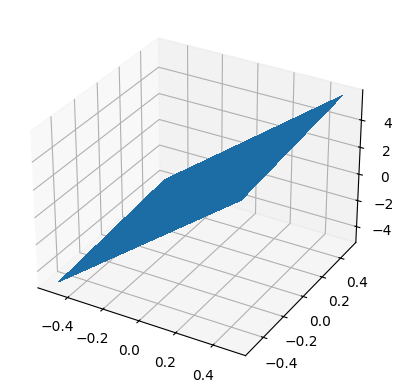

In [ ]:
fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)


Translation estimation: to estimate the parameters of the translation, we are now looking for the slope of the plane.

Method 1: estimate it using the median of the gradient. To do that, complete the gradient function.

In [343]:
def gradient(M,stepX=1.,stepY=1.):
# Computes the gradient of an image, over the rows and the column directions. StepY is the assumed gap between the rows and StepX is the assumed gap between the columns

    gy = convolve2d(M, np.array([[1],[-1]])/stepY, mode='same', boundary='symm')
    gx = convolve2d(M, np.array([[1,-1]])/stepX, mode='same', boundary='symm')
    
    return gx,gy

In [ ]:
gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)

In [ ]:
print(GX)
print(GY)

10.0
1.0


Method 2: the code below computes the least Square planar approximation of phi, enabling you how to estimate the parameters of the translation. Explain how it works.

**Réponse :**

On commence tout d'abord par lisser phi avec un filtre médian pour réduire l'effet d'un bruit et de la non périodicité. Ensuite on résoud (au sens des moindres carrés) le système A*bEst = b avec A les coordonnées des points, b l'angle phi avec filtre médian et bEst les paramètres inconnus de notre système. Ainsi ce système linéaire nous donne une approximation des paramètres de notre translation en estimant les plan le plus proche de phi (après filtrage) au sens des moindres carrés

In [391]:
def medianFilter(x,N):
    z = copyMakeBorder(x, N, N, N, N, BORDER_REPLICATE)
    y = np.zeros(np.shape(x))
    
    for r in range(np.shape(x)[0]):
        for c in range(np.shape(x)[1]):
            tmp = z[r:r+2*N+1,c:c+2*N+1]
            y[r,c] = np.median(tmp)
    return y

In [392]:
phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)

In [393]:
print(bEst)

[9.99981832 0.99999929]


**Relaunch the above code**:
- with and without noise
- with the lena image, instead of the ball image.

Each time, are you able to correctly estimate the translation? Why? Comment your results.

Nous rajoutons maintenant du bruit à ball.mat

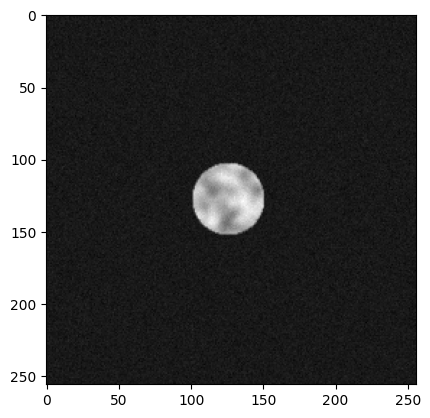

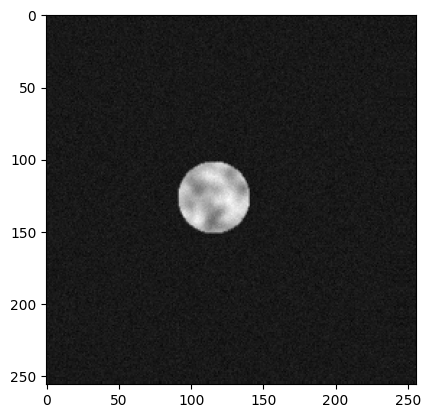

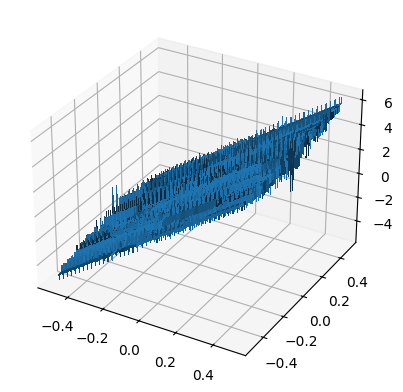

In [439]:
im1 = loadmat('ball.mat')['im1']
im1 = im1.astype('float')
N, M = np.shape(im1)

sigma = 5
im1 = im1 + sigma*np.random.randn(N,M)
plt.figure(),plt.imshow(im1,cmap='gray')
plt.plot()

horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

im2 = applyAffineMotion(im1,b)
plt.figure(),plt.imshow(im2,cmap='gray')
plt.plot()

IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)

phi = angle2D(IM1/IM2)

fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)

In [ ]:
gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)

print(GX)
print(GY)

9.959613481582664
0.38025888528216


In [ ]:
phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)
print(bEst)

[9.66202673 0.91477433]


On remarque qu'effectivement le bruit rend l'estimation moins précise en raison de la perte de périodicité. Cependant, on remarque que la deuxième méthode qui était légèrement moins précise dans le cas sans bruit est plus précise que la première méthode dans le cas avec bruit. On peut expliquer cela par le fait que le gradient est extrêment sensible au bruit tandis que la deuxième méthode utilise filtre médian qui la rend robuste au bruit.

Essayons maintenant avec une image non-périodique

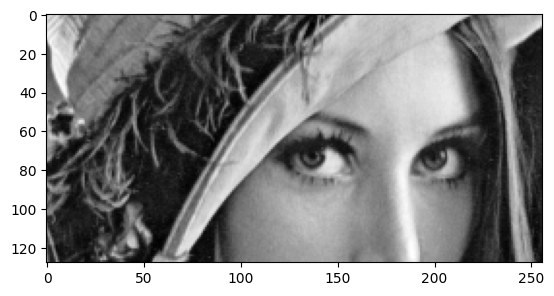

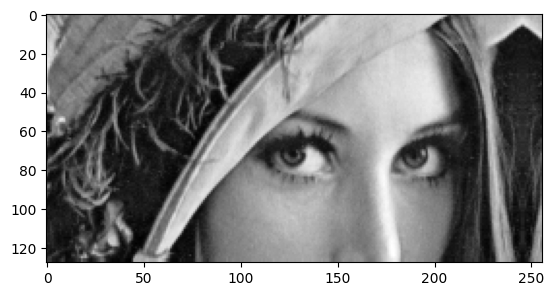

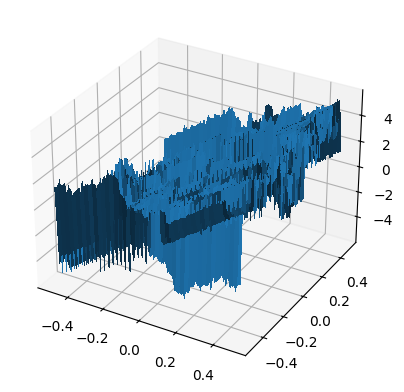

In [411]:
im1 = loadmat('lena.mat')['im1']
im1 = im1.astype('float')
N, M = np.shape(im1)

plt.figure(),plt.imshow(im1,cmap='gray')
plt.plot()

horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

im2 = applyAffineMotion(im1,b)
plt.figure(),plt.imshow(im2,cmap='gray')
plt.plot()

IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)

phi = angle2D(IM1/IM2)

fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)

In [412]:
gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)

print(GX)
print(GY)

8.920841577295562
0.0


In [413]:
phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)
print(bEst)

[7.90761829 0.01702052]


On remarque que pour une image non périodique, les 2 méthodes sont beaucoup moins efficaces (encore moins que pour une image périodique bruitée), elles n'arrivent notamment pas à estimer la translation verticale dans ce cas là. Ici la première méthode est plus efficace. En effet, contrairement au bruit qui créait de nombreux pics fins et éparses ce qui rendait le filtre médian avec estimation de plan par moindres plus efficace que la méthode par gradient, ici il y a des grosses variations qui ne sont pas filtrées et qui faussent le plan estimé contrairement au gradient qui reste "globalement" plus fiable (car on prend la médiane des gradients).

# II-Indirect parametric estimation
In this last part, we will perform indirect parametric estimation. The movement vector field will be estimated by 1) block matching; 2) optic flow. **You have to reuse here the functions that you implemented during the first practical work**. Each time, you will then estimate the translation by taking the median of the estimated vector field.

Perform the experiment without and with noise (you can then take sigma = 2).

Finally, compare all the parametric estimation methods when the translation values are not integer.

In [ ]:
im1 = loadmat('lena.mat')['im1']
im1 = im1.astype('float')

N, M = np.shape(im1)

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x2acc34996a0>)

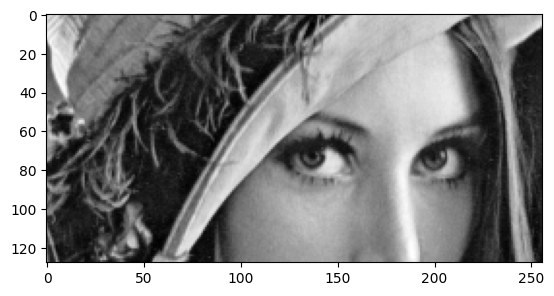

In [423]:
# Potentially add noise to the image
sigma = 0
im1 = im1 + sigma*np.random.randn(N,M)
plt.figure(),plt.imshow(im1,cmap='gray')

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x2acc8022ff0>)

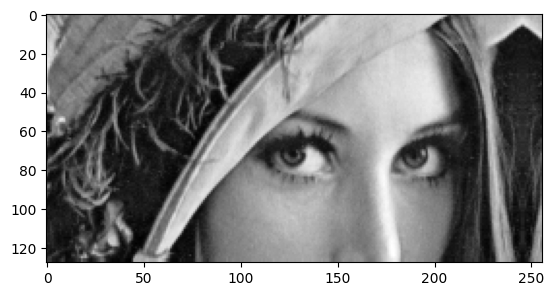

In [424]:
horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b)
plt.figure(),plt.imshow(im2,cmap='gray')

In [425]:
#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) 
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV

#%%
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV


#%%
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    search_range = range(-search,search+1)
    
    # Non-regularized search
    if lamb == 0.:
        
        for row in range(0,cur.shape[0],brow): # for each block in the current image, find the best corresponding block in the reference image
            for col in range(0,cur.shape[1],bcol):
                # current block selection
                B = cur[row:row+brow,col:col+bcol] # Block

                # Initialization:
                bestvect = (0,0)
                costMin = float('inf')
                
                Rbest = B
                
                # Loop on candidate displacement vectors
                for dcol in search_range: # dcol = candidate displacement vector over the columns
                    for drow in search_range:# rcol = candidate displacement vector over the rows

                        row_start = row + drow + extension
                        col_start = col + dcol + extension
                        curr_ref_block = ref_extended[row_start:row_start+brow, col_start:col_start+bcol]
                        curr_cost = np.sum((B - curr_ref_block)**2)
                        
                        if curr_cost < costMin: # Save the results if they are better than the previous ones
                            costMin = curr_cost
                            Rbest = curr_ref_block
                            bestvect = (drow,dcol)
                        
                mvf[row:row+brow,col:col+bcol,0]= bestvect[0] # Once the loop is over, save the best row displacement field
                mvf[row:row+brow,col:col+bcol,1]= bestvect[1] # Once the loop is over, save the best column displacement field
                prediction[row:row+brow,col:col+bcol]= Rbest
                
    else: # Regularized search

        for row in range(0,cur.shape[0]-brow,brow): # for each block in the current image, find the best corresponding block in the reference image
            for col in range(0,cur.shape[1]-bcol,bcol):
                # current block selection
                B = cur[row:row+brow,col:col+bcol] # Block

                # Initialization:

                bestvect = (0,0)
                costMin = float('inf')
                
                Rbest = B
                
                # Loop on candidate displacement vectors
                for dcol in search_range: # dcol = candidate displacement vector over the columns
                    for drow in search_range:# rcol = candidate displacement vector over the rows

                        row_start = row + drow + extension
                        col_start = col + dcol + extension
                        curr_ref_block = ref_extended[row_start:row_start+brow, col_start:col_start+bcol]

                        vect = np.array([drow,dcol])

                        pV = computePredictor(row,col,brow,bcol,mvf,ref,cur)

                        dx,dy = vect - pV

                        cost = np.sum((curr_ref_block-B)**2) + lamb * np.sqrt(dx**2 + dy**2)
                        
                        if cost < costMin: # Save the results if they are better than the previous ones
                            costMin = cost
                            Rbest = curr_ref_block  
                            bestvect = vect
                        
                mvf[row:row+brow,col:col+bcol,0]= bestvect[0] # Once the loop is over, save the best row displacement field
                mvf[row:row+brow,col:col+bcol,1]= bestvect[1] # Once the loop is over, save the best column displacement field
                prediction[row:row+brow,col:col+bcol]=Rbest
                
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

In [426]:
def displayMVF(I,mvf,subsamp):
    
    row,col = np.shape(I)
    
    # Subsample dense MVF 
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]
    
    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)
    
    # Show image
    plt.figure()
    plt.imshow(I,cmap='gray')

    plt.quiver(X, Y, vectCol,-vectRow)

    
    return

10.0
1.0


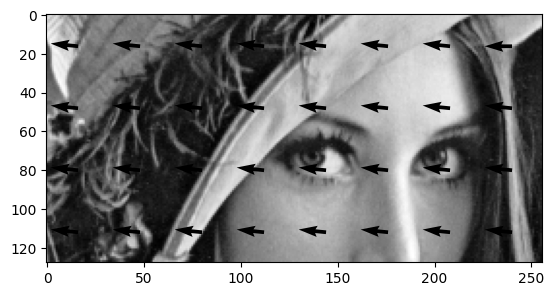

In [432]:
lamb = 0
mvf,prediction = me_ssd(im2,im1,32,32,10,lamb)
displayMVF(im1,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(-bx)
print(-by)

On peut voir ici que contrairement aux méthodes d'estimation paramétriques directs, la méthode indirect par "block matching" est bien plus précise pour les images non périodiques.

Estimation with optic flow

In [433]:
def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx;
    fy=-fy;

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337
    
    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)
    
    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """
    
    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)
    
    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()
    
    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)
    
    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])
    
    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg = convolve2d(u, kernel_1, mode='same', boundary='symm')
        vAvg = convolve2d(v, kernel_1, mode='same', boundary='symm')
        
        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = uAvg - fx*(uAvg*fx +vAvg*fy + ft) / (alpha**2 + fx**2 + fy**2 + ft**2)
        v = vAvg - fy*(uAvg*fx + vAvg*fy + ft) / (alpha**2 + fx**2 + fy**2 + ft**2)
        
    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

6.180281775793819
0.5906518668680953


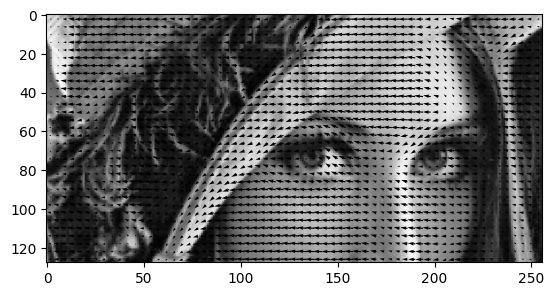

In [435]:
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(-bx)
print(-by)

La méthode d'estimation par flow optique est quant à elle moins efficace que celle par "block matching" pour les images non périodiques. Ses performances sont comparables aux méthodes d'estimation direct vues précédements même si on remarque que la méthode par flow optique estime mieux la translation verticale (et moins bien l'horizontale).

On essaye maintenant les 2 méthodes précédentes en ajoutant du bruit

In [448]:
im1 = loadmat('lena.mat')['im1']
im1 = im1.astype('float')

N, M = np.shape(im1)

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x2acc59a2210>)

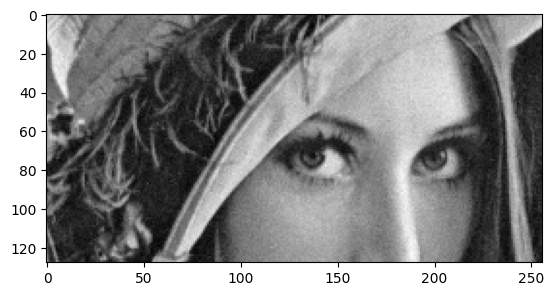

In [449]:
# Potentially add noise to the image
sigma = 5
im1 = im1 + sigma*np.random.randn(N,M)
plt.figure(),plt.imshow(im1,cmap='gray')

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x2acc8a4fd40>)

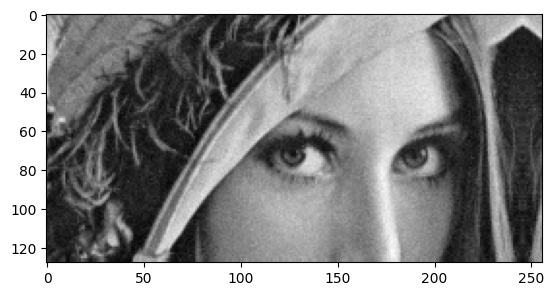

In [450]:
horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b)
plt.figure(),plt.imshow(im2,cmap='gray')

10.0
1.0


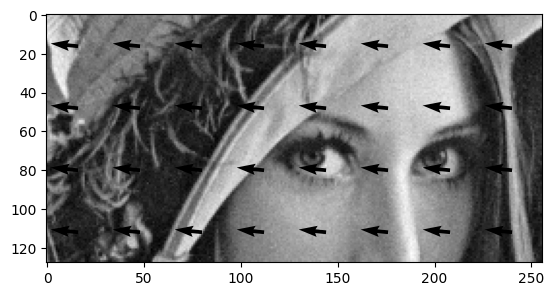

In [451]:
lamb = 0
mvf,prediction = me_ssd(im2,im1,32,32,10,lamb)
displayMVF(im1,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(-bx)
print(-by)

6.123208233349493
0.612111589496647


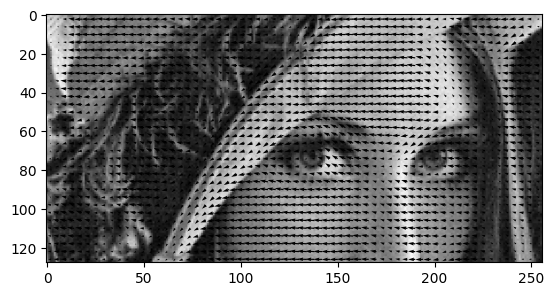

In [452]:
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(-bx)
print(-by)

On remarque que les 2 méthodes ne sont pas influencées par le bruit, ce qui les rend plus efficaces (dans le cas bruité) que les méthodes d'estimation directes.

Nous allons maintenant tester les 4 méthodes pour des translation non entières

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x2acd03d13a0>)

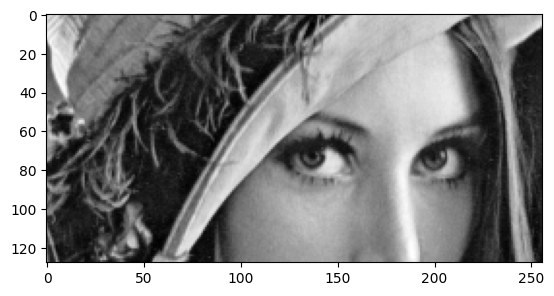

In [461]:
im1 = loadmat('lena.mat')['im1']
im1 = im1.astype('float')

N, M = np.shape(im1)

plt.figure(),plt.imshow(im1,cmap='gray')

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x2acd035d490>)

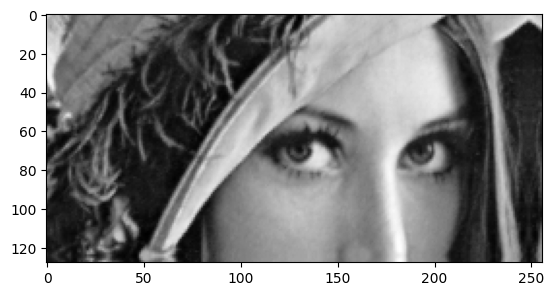

In [462]:
horiz_displacement = 6.7
vert_displacement  = 3.3
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b)
plt.figure(),plt.imshow(im2,cmap='gray')

Méthode 1

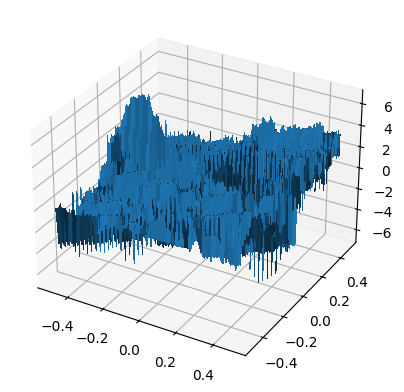

In [463]:
IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)

phi = angle2D(IM1/IM2)

fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)

In [464]:
gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)

print(GX)
print(GY)

5.449165266261836
-3.934181766759588


Méthode 2

In [465]:
phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)
print(bEst)

[ 3.10648291 -0.44986109]


Méthode 3

7.0
3.0


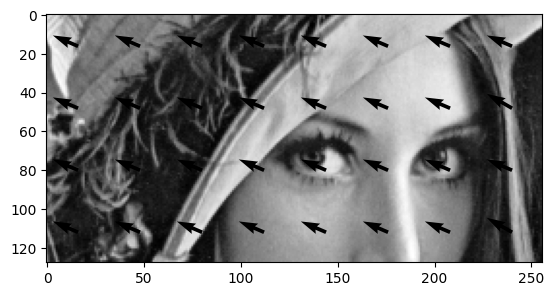

In [466]:
lamb = 0
mvf,prediction = me_ssd(im2,im1,32,32,10,lamb)
displayMVF(im1,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(-bx)
print(-by)

Méthode 4

4.198978117219195
2.295662774596302


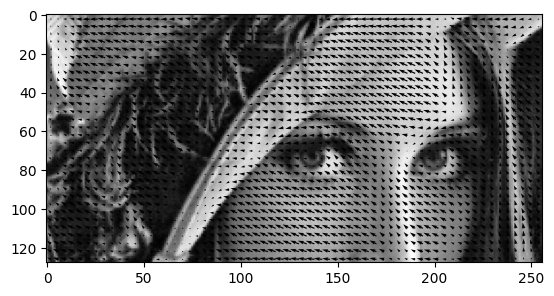

In [468]:
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(-bx)
print(-by)

On remarque que la première méthode est très peu précise avec une très mauvaise estimation de la translation verticale. La deuxième méthode est également peu précise mais plus que la première. La troisième méthode par "block matching" semble être la plus précise dans ce cas mais par construction elle est incapable de déterminer des translation non entières. La dernière méthode par flow optique semble la plus adaptée à ce genre d'estimations car malgré une précision moins importante que la troisième méthode, elle peut estimer des translations non entières et reste plus précise que les 2 premières méthodes.